## Dog Breed Classification : Totality Corp Assignment

### Part-1: Build a dog breed image classification model with the architecture specified below. ​

- The classifier should only predict scores for these breeds : beagle, chihuahua, doberman, french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound, tibetan_mastiff.
Any of these frameworks can be used : Tensorflow, Keras, Pytorch, Caffee.
- The classifier should only be built using Resnet50 CNN architecture.
Evaluation metrics i.e Accuracy, Confusion Matrix, F1 Score, ROC-AUC Score shall be calculated
on test data.
- The entire process should be clearly logged in a Jupyter Notebook and uploaded to a public github repo, the exact link to this notebook is to be submitted as a result of this assignment.

Dataset​ - ​https://www.kaggle.com/c/dog-breed-identification/data

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import AveragePooling2D, Dense, Flatten, Dropout
from keras.applications import ResNet50
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, auc,roc_curve, plot_roc_curve
import seaborn as sns
from PIL import Image

#### Downloading the Dataset

In [2]:
# DOWNLOAD AND UNZIP THE DATASET FROM KAGGLE
DATASET_URL = 'https://www.kaggle.com/c/dog-breed-identification/data'
od.download(DATASET_URL)
!unzip -q /content/dog-breed-identification/dog-breed-identification.zip

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashiishkarhade
Your Kaggle Key: ··········


  0%|          | 3.00M/691M [00:00<00:43, 16.6MB/s]

100%|██████████| 691M/691M [00:10<00:00, 68.0MB/s]


In [3]:
TRAIN_PATH = '/content/train'
TEST_PATH = '/content/test'

#### Data Preparation and Cleaning

In [4]:
# Loading the CSV file
df = pd.read_csv('/content/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# shape of our labes.csv
print(df.shape)

(10222, 2)


In [6]:
# Adjusting the labels.csv to feed into our Keras ImageDataGenerators
df['id'] = df['id'] + '.jpg'
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [7]:
dog_categories = ['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
len(dog_categories)

10

In [8]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    validation_split=0.1,
    rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df, 
    directory=TRAIN_PATH, 
    x_col='id', 
    y_col='breed', 
    target_size=(512, 512), 
    class_mode='categorical', 
    classes=dog_categories,
    subset='training')

Found 757 validated image filenames belonging to 10 classes.


In [10]:
val_generator = train_datagen.flow_from_dataframe(
    dataframe=df, 
    directory=TRAIN_PATH, 
    x_col='id', 
    y_col='breed', 
    target_size=(512, 512), 
    class_mode='categorical', 
    classes=dog_categories,
    subset='validation')

Found 84 validated image filenames belonging to 10 classes.


In [12]:
print(train_generator.class_indices)

{'beagle': 0, 'chihuahua': 1, 'doberman': 2, 'french_bulldog': 3, 'golden_retriever': 4, 'malamute': 5, 'pug': 6, 'saint_bernard': 7, 'scottish_deerhound': 8, 'tibetan_mastiff': 9}


#### Preparation of ResNet50 Model

In [13]:
resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(512,512, 3)
)

94773248/94765736 [==============================] - 1s 0us/step


In [14]:
#print(resnet.summary())

In [15]:
head = resnet.output
head = AveragePooling2D(pool_size=(7, 7))(head)
head = Flatten(name="flatten")(head)
head = Dense(256, activation="relu")(head)
head = Dropout(0.25)(head)
head = Dense(10, activation="softmax")(head)

In [16]:
model = Model(inputs=resnet.input, outputs=head)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
for layer in resnet.layers:
	layer.trainable = False

In [19]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [20]:
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#### ResNet50 Model Training

In [25]:
batch_size = 64
nbEpochs = 20

In [21]:
history = model.fit(train_generator, 
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data=val_generator, 
                    validation_steps = val_generator.samples // batch_size,
                    epochs = nbEpochs)

Epoch 1/20
11/11 [==============================] - 61s 2s/step - loss: 2.6185 - accuracy: 0.1634 - val_loss: 1.7623 - val_accuracy: 0.3750
Epoch 2/20
11/11 [==============================] - 25s 2s/step - loss: 1.8196 - accuracy: 0.3767 - val_loss: 1.6553 - val_accuracy: 0.4688
Epoch 3/20
11/11 [==============================] - 25s 2s/step - loss: 1.3776 - accuracy: 0.5804 - val_loss: 1.0804 - val_accuracy: 0.6875
Epoch 4/20
11/11 [==============================] - 25s 2s/step - loss: 1.0453 - accuracy: 0.6621 - val_loss: 0.9920 - val_accuracy: 0.7188
Epoch 5/20
11/11 [==============================] - 24s 2s/step - loss: 0.7760 - accuracy: 0.7638 - val_loss: 0.6845 - val_accuracy: 0.8438
Epoch 6/20
11/11 [==============================] - 25s 2s/step - loss: 0.6340 - accuracy: 0.7952 - val_loss: 0.7688 - val_accuracy: 0.8125
Epoch 7/20
11/11 [==============================] - 25s 2s/step - loss: 0.6082 - accuracy: 0.8005 - val_loss: 0.5771 - val_accuracy: 0.8750
Epoch 8/20
11/11 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


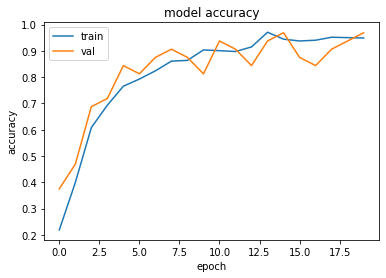

In [29]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()
plt.savefig('accuracy.png')

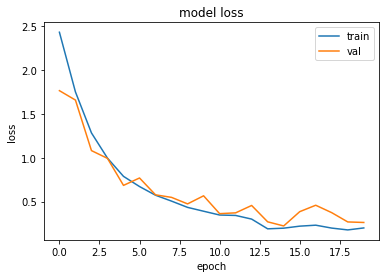

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.savefig('loss.png')

In [30]:
model.save('final_model.h5')

#### Metrics

In [ ]:
#Accuracy, Confusion Matrix, F1 Score, ROC-AUC Score shall be calculated on test data.

In [31]:
y_true = val_generator.classes
vals = val_generator.filepaths

In [32]:
y_preds = []
y_scores = []
for fpath in vals:
    img = Image.open(fpath)
    img = img.resize((512, 512))
    img = np.array(img)
    img = img.reshape(-1, 512, 512, 3)
    pros = model.predict(img)
    y_scores.append(pros)
    pros = np.argmax(pros)
    y_preds.append(pros)
y_scores = np.array(y_scores)
y_scores = y_scores.reshape((84, 10))

Classification Report

In [33]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.75      0.86         8
           2       0.89      0.89      0.89         9
           3       1.00      1.00      1.00         3
           4       0.78      0.88      0.82         8
           5       0.93      1.00      0.96        13
           6       1.00      1.00      1.00        10
           7       0.80      0.80      0.80         5
           8       1.00      0.93      0.97        15
           9       0.80      0.80      0.80         5

    accuracy                           0.92        84
   macro avg       0.91      0.90      0.90        84
weighted avg       0.92      0.92      0.92        84



Accuracy Score

In [34]:
asc = accuracy_score(y_true, y_preds)
print(f"ACCURACY SCORE : {asc}")

ACCURACY SCORE : 0.9166666666666666


F1 Score

In [35]:
f1 = f1_score(y_true, y_preds, average='macro')
print(f"F1-SCORE : {f1}")

F1-SCORE : 0.903921783272696


ROC AUC SCORE

In [36]:
roc_auc_score(y_true, y_scores, multi_class='ovo')

0.9975590574548908

Confusion Matrix

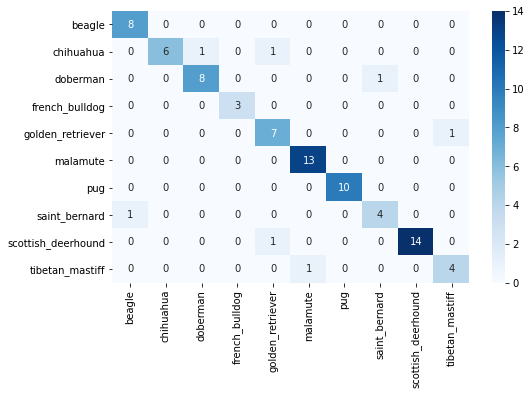

In [40]:
cm = confusion_matrix(y_true, y_preds)
df_cm = pd.DataFrame(cm, index = dog_categories, columns = dog_categories)
plt.figure(figsize = (8,5))
hp = sns.heatmap(df_cm, annot=True, cmap='Blues')

### Part - 2:​ ( Extra brownie points! )

- Build an API around the model inference pipeline which takes in an Input image in Base64 and responds with the appropriate dog breed. Any framework of choice can be used but the API needs to follow REST architecture and shall be deployed publicly for us to test.

- The input format needs to be :
```
{
image : <base64 encoded image> 
}
```

- Expected response:
```
{
breed : <resulting label>
score : <prediction score of the above label > 
}
```

- A working api endpoint needs to be submitted as a result of this assignment.